[IMP] The code takes around 16 mins for execution. Recommended to run earliest.



# 1. System Selection: Elastic Pendulum

The elastic pendulum (spring pendulum) is a system with **two degrees of freedom** described by the following equations of motion:

### Governing Equations:
$$
\begin{align*}
\ddot{r} &= r\dot{\theta}^2 + g\cos\theta - \frac{k}{m}(r - L_0) \\
\ddot{\theta} &= \frac{-g\sin\theta - 2\dot{r}\dot{\theta}}{r}
\end{align*}
$$

### State Vector:
the system is represented using a 4-dimensional state vector:
$$
\mathbf{x} = [r, \dot{r}, \theta, \dot{\theta}]^T
$$

Where:
- $r$: Spring length from pivot (m)
- $\dot{r}$: Radial velocity (m/s)  
- $\theta$: Angle from vertical (rad)
- $\dot{\theta}$: Angular velocity (rad/s)

### Physical Parameters Selected:
- Mass: $m = 1.0$ kg
- Spring constant: $k = 20.0$ N/m
- Natural length: $L_0 = 1.0$ m
- Gravity: $g = 9.81$ m/s²

### Initial Conditions:
- Initial stretch: $r_0 = 2.0$ m
- Initial angle: $\theta_0 = \pi/3$ radians
- Zero initial velocities: $\dot{r}_0 = 0$, $\dot{\theta}_0 = 0$

# 2. Generating Training Data

## Data Generation Strategy

The ground truth data is generated by numerically solving the elastic pendulum equations using `scipy.integrate.solve_ivp` with the RK45 method (Dormand-Prince 4/5 order adaptive solver).

### Time Parameters:
- **Time span**: 0 to 4 seconds
- **Evaluation points**: 200 time points
- **Solver**: RK45 with adaptive step sizing for high accuracy

### Data Processing:
1. Solve ODE system to get state trajectories
2. Convert to PyTorch tensors
3. Normalize data to zero mean and unit variance for stable training
4. Shape: (200 time points × 4 state variables)

The generated data serves as the **ground truth** for training Neural ODE.





# 3. Neural ODE Model Architecture

## Model Design Choices

The NODE uses a neural network to represent the derivative function $f_\theta(\mathbf{x})$ that approximates the true system dynamics:

### Architecture:
- **Input layer**: 4 neurons (matching state dimension [r, ṙ, θ, θ̇])
- **Hidden layers**: 3 layers with 64 neurons each
- **Activation**: Tanh
- **Output layer**: 4 neurons (predicting [ṙ, ̈r, θ̇, ̈θ])

### Mathematical Formulation:
The Neural ODE learns:
$$
\frac{d\mathbf{x}}{dt} = f_\theta(\mathbf{x})
$$
where $f_\theta$ is neural network, and the ODE solver integrates this to get trajectories.

### Key Features:
- **Weight initialization**: Xavier normal for stable training
- **ODE solver**: Dormand-Prince 5(4) adaptive solver
- **Memory efficiency**: Uses adjoint method for gradient computation

# 4A. Loss Function and Optimization

## Loss Function Design

**Mean Squared Error (MSE)** is used to calculate error between predicted and true trajectories:

### Primary Loss:
$$
\mathcal{L}_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} \left\| \mathbf{x}_{\text{pred}}^{(i)} - \mathbf{x}_{\text{true}}^{(i)} \right\|^2
$$

### Optimization Strategy:
- **Optimizer**: Adam with learning rate 5e-3
- **Learning rate scheduling**: Reduce LR on plateau
- **Gradient clipping**: Norm clipping at 1.0 for stability
- **Weight decay**: L2 regularization (1e-5) to prevent overfitting

### Mathematical Optimization:
We minimize the loss using gradient descent:
$$
\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}(\theta)
$$
where gradients are computed via the adjoint sensitivity method for memory efficiency.

#4B.Optimized Learning Curriculum
The NODE was trained using the MSE initially for the considered epochs. However, it resulted in large deviations compared to true trajectory.

This happens becuase NODE converged to trivial solutions where the learned dynamics are near-zero (ṙ ≈ 0, θ̇ ≈ 0). This is mainly a result of:
- Predicting 'no motion' gives decent loss initially
- The optimizer gets stuck in poor local minima

Therefore, **'Loss Function Modification'** technique is used to reduce the error and mathch the expected trajectory/behaviour.

The method is executed using **'Curriculum Learning'** concept which is training strategy that gradually increases complexity during training. For NeODEs, a two-phase approach is used to avoid trivial solutions.


**Phase 1 (Epochs 0-300): Standard Training (reconstruction Loss)**
$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}}
$$

Purpose: Minimize difference between predicted and true trajectories

&nbsp;&nbsp;

**Phase 2 (Epochs 300+): Anti-Trivial Penalty**
$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \lambda \cdot \max(0, \epsilon - \|\nabla\mathbf{x}\|)
$$
Purpose: Prevent collapse to trivial solutions where f_θ(x) ≈ 0
- $\|\nabla\mathbf{x}\|$ is the norm of predicted derivatives
- $\epsilon$ is a threshold (0.15) below which dynamics are considered "trivial"
- $\lambda$ is a small weight (0.001) for the anti-trivial penalty

**How it Functions:**

1. **First 300 epochs**: Learn basic dynamics without constraints
2. **After 300 epochs**: Only penalize if derivatives are too small and loss is still high
3. **Minimal overhead**: Anti-trivial checks every 10 epochs for efficiency

This approach ensures the model learns meaningful dynamics without significant computational cost and time.

##5.Plots and Comparision

The predicted NODE trajectory and true trajectory are overlayed to visulaise the results. Various plots of trajectories in polar and cartetian co-ordinates as well as the phase potraints are developed to visulaise the trajectories of both methods. The phase plots are especially important for this case as they reveal if the NODE captures the correct dynamics, stability, oscillation patterns and energy exchange between spring and pendulum.

<br>

The X vs Y plot depicts that the NODE successfully captures the elastic pendulum's complex orbital dynamics, accurately reproducing the true trajectory with minimal deviation. The overlay comparisons show excellent agreement in both the radial oscillations and angular motion, demonstrating effective learning of the coupled spring-pendulum physics.

<br>

The training loss graph reveals the effectiveness of _'Cirriculum learning'_ method. The loss functions shows the gradual descent initially (during phase 1). However, as the _'Anti-Trivial Penalty'_ is introduced after epoch 300, the loss function declines sharply.

In [ ]:
!pip install torchdiffeq

Using device: cpu
Elastic Pendulum System:
Spring constant: k = 20.0 N/m
Initial stretch: r0 = 2.0 m
Initial angle: θ0 = 60.0°
Training data shape: torch.Size([200, 4])
Starting Neural ODE training...
Epoch    0, Loss: 3.980057, LR: 0.005000
Epoch  200, Loss: 0.502492, LR: 0.005000
Epoch  400, Loss: 0.517474, LR: 0.005000
Epoch  600, Loss: 0.126455, LR: 0.005000
Epoch  800, Loss: 0.043804, LR: 0.003500


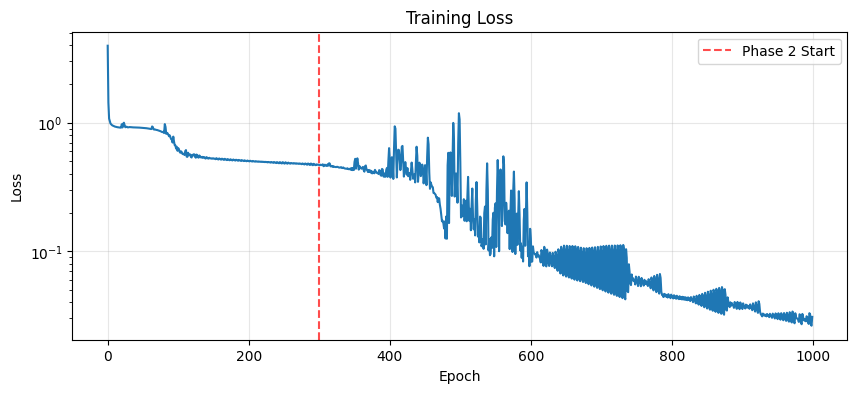

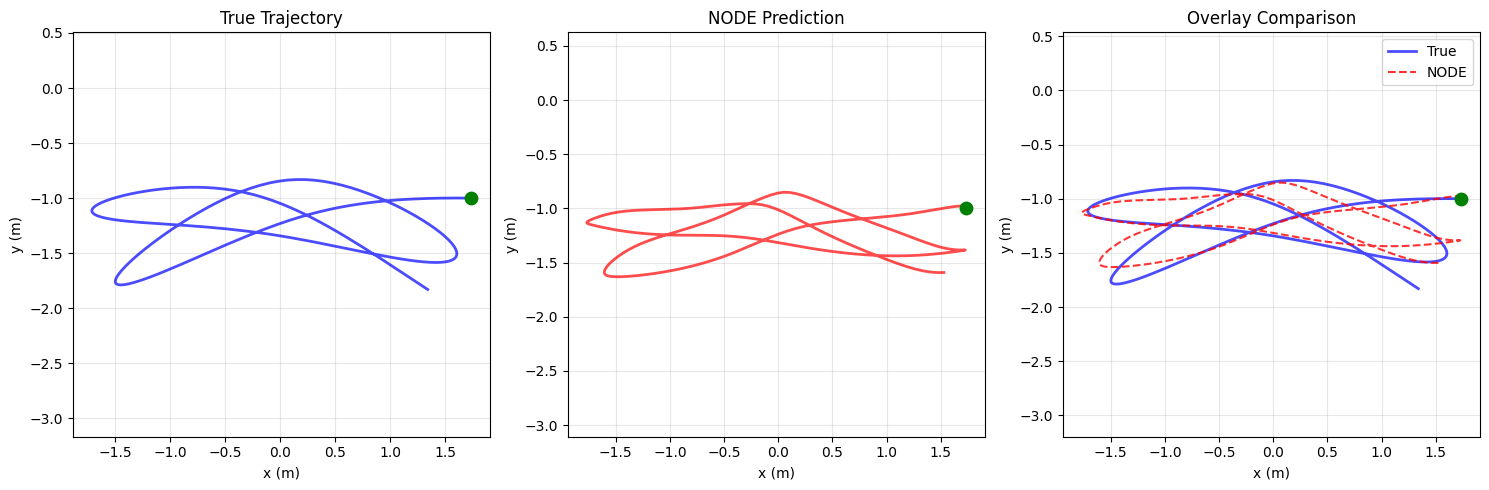


QUANTITATIVE RESULTS
Overall MSE:  0.111460
Overall RMSE: 0.333856
Overall MAE:  0.209522

Errors per variable:
     Spring Length r (m): RMSE = 0.040679
Radial Velocity r_dot (m/s): RMSE = 0.299838
             Angle θ (rad): RMSE = 0.072377
Angular Velocity θ_dot (rad/s): RMSE = 0.590799


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from torchdiffeq import odeint

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 1. SYSTEM IDENTIFICATION (ELASTIC PENDULUM)
# ============================================================================

def elastic_pendulum_system(t, state, m=1.0, k=20.0, L0=1.0, g=9.81):
    """Elastic pendulum system equations"""
    r, r_dot, theta, theta_dot = state
    r_ddot = r * theta_dot**2 + g * np.cos(theta) - (k/m) * (r - L0)
    theta_ddot = (-g * np.sin(theta) - 2 * r_dot * theta_dot) / r
    return [r_dot, r_ddot, theta_dot, theta_ddot]

def polar_to_cartesian(r, theta):
    x = r * np.sin(theta)
    y = -r * np.cos(theta)
    return x, y

# System parameters
m = 1.0
k = 20.0
L0 = 1.0
g = 9.81
initial_r = 2.0
initial_angle = np.pi/3


# ============================================================================
# 2. DATA PREPARATION AND GROUND TRUTH (TRAJECTORY) GENERATION
# ============================================================================

# Time parameters
t_span = (0, 4) #(Time interval selected - 4 secs for reduced computational time)
t_eval = np.linspace(t_span[0], t_span[1], 200)

initial_state = [initial_r, 0.0, initial_angle, 0.0]

print("Elastic Pendulum System:")
print(f"Spring constant: k = {k} N/m")
print(f"Initial stretch: r0 = {initial_r} m")
print(f"Initial angle: θ0 = {np.degrees(initial_angle):.1f}°")

# Generate ground truth trajectory
solution = solve_ivp(elastic_pendulum_system, t_span, initial_state,
                     t_eval=t_eval, method='RK45', args=(m, k, L0, g))
t_true = solution.t
state_true = solution.y

# Convert to Cartesian coordinates
x_true_cart, y_true_cart = polar_to_cartesian(state_true[0], state_true[2])

# Convert to PyTorch tensors
t_tensor = torch.tensor(t_true, dtype=torch.float32)
state_tensor = torch.tensor(state_true.T, dtype=torch.float32)

# Normalize data
state_mean = state_tensor.mean(dim=0)
state_std = state_tensor.std(dim=0)
state_normalized = (state_tensor - state_mean) / state_std

print(f"Training data shape: {state_normalized.shape}")


# ============================================================================
# 3. NODE MODEL ARCHITECTURE
# ============================================================================

class ElasticPendulumODE(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=3):
        super(ElasticPendulumODE, self).__init__()

        layers = [nn.Linear(4, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 4))

        self.net = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            nn.init.constant_(module.bias, 0.0)

    def forward(self, t, state):
        return self.net(state)

class NeuralODE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func

    def forward(self, x0, t):
        return odeint(self.ode_func, x0, t, method='dopri5')

# ============================================================================
# 4. LOSS FUNCTION AND OPTIMISED LEARNING ALGORITHM
# ============================================================================

def train_curriculum_learning(model, train_t, train_x, num_epochs=1000, lr=5e-3):
    model.to(device)
    train_t, train_x = train_t.to(device), train_x.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.7)

    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        x_pred = model(train_x[0], train_t)
        reconstruction_loss = torch.mean((x_pred - train_x) ** 2)

        # Curriculum learning strategy
        if epoch < 300:
            # Phase 1: Standard training
            total_loss = reconstruction_loss
        else:
            # Phase 2: Check for trivial solutions periodically
            if epoch % 10 == 0:
                with torch.no_grad():
                    sample_idx = torch.randint(0, train_x.shape[0], (3,))
                    sample_states = train_x[sample_idx]
                    derivatives = model.ode_func(torch.tensor(0.0), sample_states)
                    derivative_norm = torch.mean(torch.norm(derivatives, dim=1)).item()

                if derivative_norm < 0.15 and reconstruction_loss.item() > 0.1:
                    anti_trivial_penalty = 0.001 * (0.15 - derivative_norm)
                    total_loss = reconstruction_loss + anti_trivial_penalty
                else:
                    total_loss = reconstruction_loss
            else:
                total_loss = reconstruction_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(total_loss)

        losses.append(total_loss.item())

        if epoch % 200 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch:4d}, Loss: {total_loss.item():.6f}, LR: {current_lr:.6f}')

    return losses

# Create and train the model
ode_func = ElasticPendulumODE(hidden_dim=64, num_layers=3)
model = NeuralODE(ode_func)

print("Starting Neural ODE training...")
losses = train_curriculum_learning(model, t_tensor, state_normalized, num_epochs=1000, lr=5e-3)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.axvline(x=300, color='red', linestyle='--', alpha=0.7, label='Phase 2 Start')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================================
# 5. PREDICTION AND COMPARISON
# ============================================================================

# Generate predictions
with torch.no_grad():
    state_pred_normalized = model(state_normalized[0].to(device), t_tensor.to(device))
    state_pred_normalized = state_pred_normalized.cpu()
    state_pred = state_pred_normalized * state_std + state_mean

state_pred_np = state_pred.numpy()
x_pred_cart, y_pred_cart = polar_to_cartesian(state_pred_np[:, 0], state_pred_np[:, 2])

# Plot trajectory comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_true_cart, y_true_cart, 'b-', alpha=0.7, linewidth=2, label='True')
plt.scatter(x_true_cart[0], y_true_cart[0], color='green', s=80, zorder=5)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('True Trajectory')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(x_pred_cart, y_pred_cart, 'r-', alpha=0.7, linewidth=2, label='NODE')
plt.scatter(x_pred_cart[0], y_pred_cart[0], color='green', s=80, zorder=5)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('NODE Prediction')
plt.axis('equal')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(x_true_cart, y_true_cart, 'b-', alpha=0.7, linewidth=2, label='True')
plt.plot(x_pred_cart, y_pred_cart, 'r--', alpha=0.8, linewidth=1.5, label='NODE')
plt.scatter(x_true_cart[0], y_true_cart[0], color='green', s=80, zorder=5)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Overlay Comparison')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. QUANTITATIVE RESULTS
# ============================================================================

mse_total = np.mean((state_true.T - state_pred_np) ** 2)
rmse_total = np.sqrt(mse_total)
mae_total = np.mean(np.abs(state_true.T - state_pred_np))

print("\n" + "="*50)
print("QUANTITATIVE RESULTS")
print("="*50)
print(f"Overall MSE:  {mse_total:.6f}")
print(f"Overall RMSE: {rmse_total:.6f}")
print(f"Overall MAE:  {mae_total:.6f}")

# Calculate errors for each variable
variables = ['Spring Length r', 'Radial Velocity r_dot', 'Angle θ', 'Angular Velocity θ_dot']
units = ['m', 'm/s', 'rad', 'rad/s']

print("\nErrors per variable:")
for i, (var, unit) in enumerate(zip(variables, units)):
    var_mse = np.mean((state_true[i] - state_pred_np[:, i]) ** 2)
    var_rmse = np.sqrt(var_mse)
    print(f"{var:>20} ({unit}): RMSE = {var_rmse:.6f}")

print("="*50)

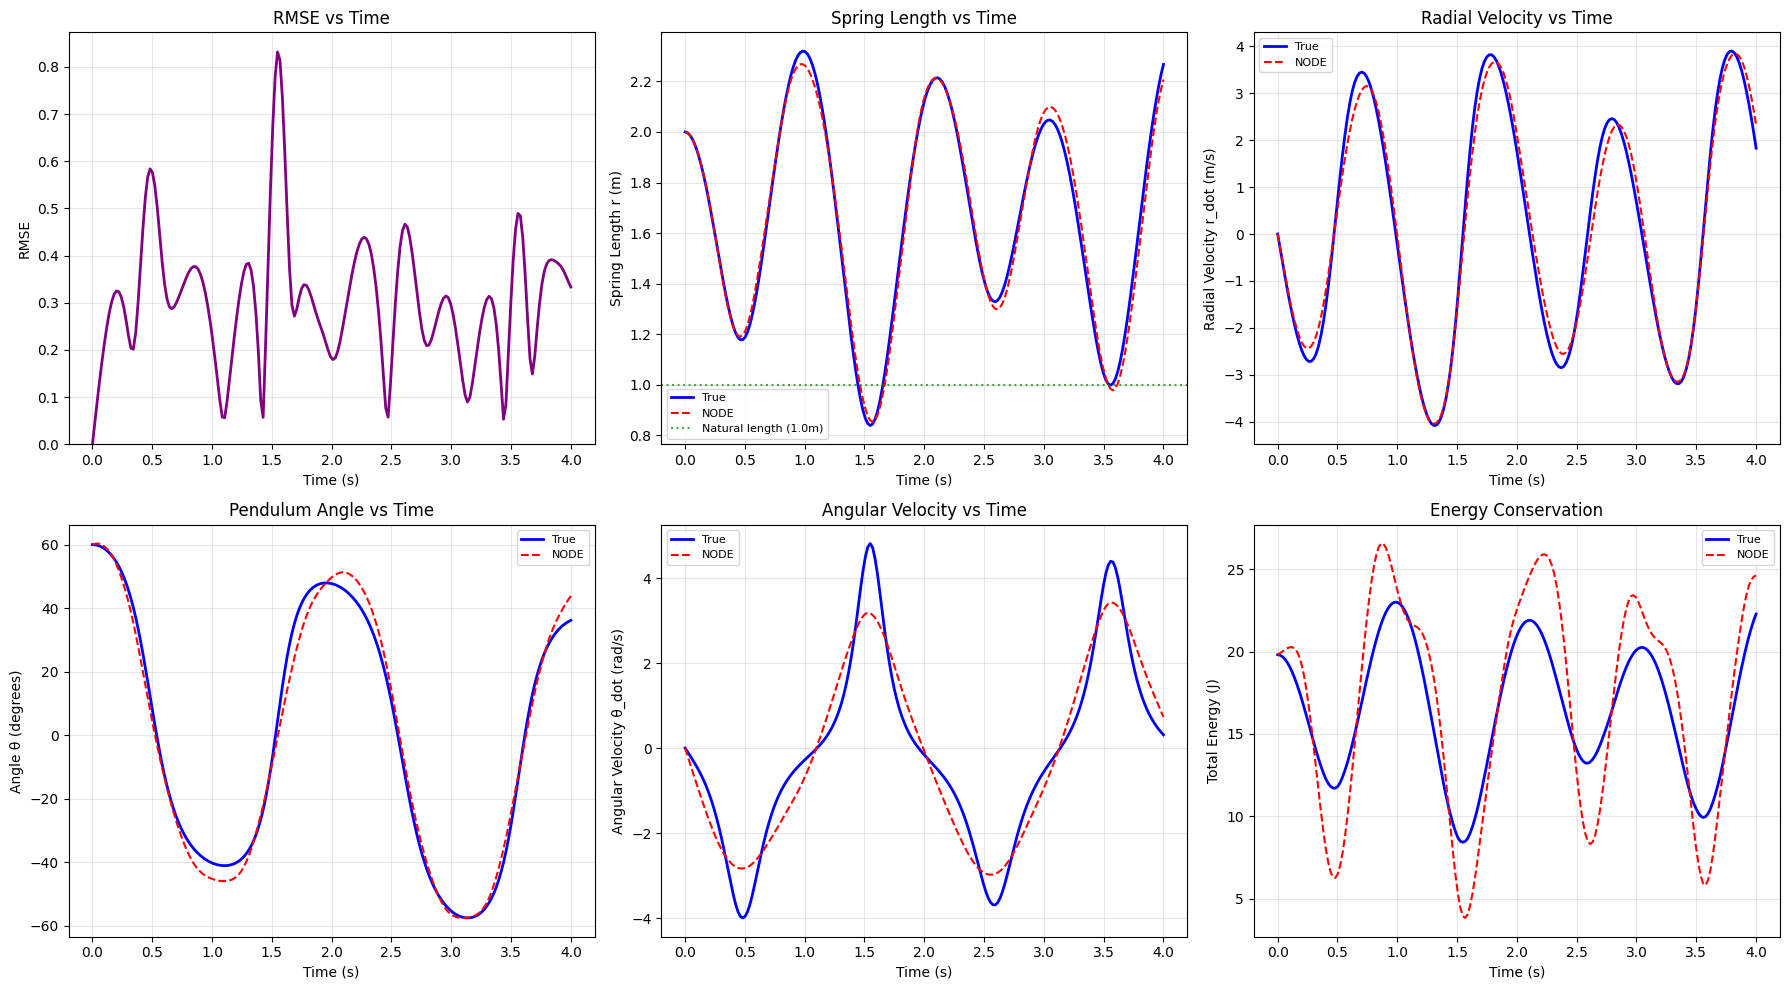

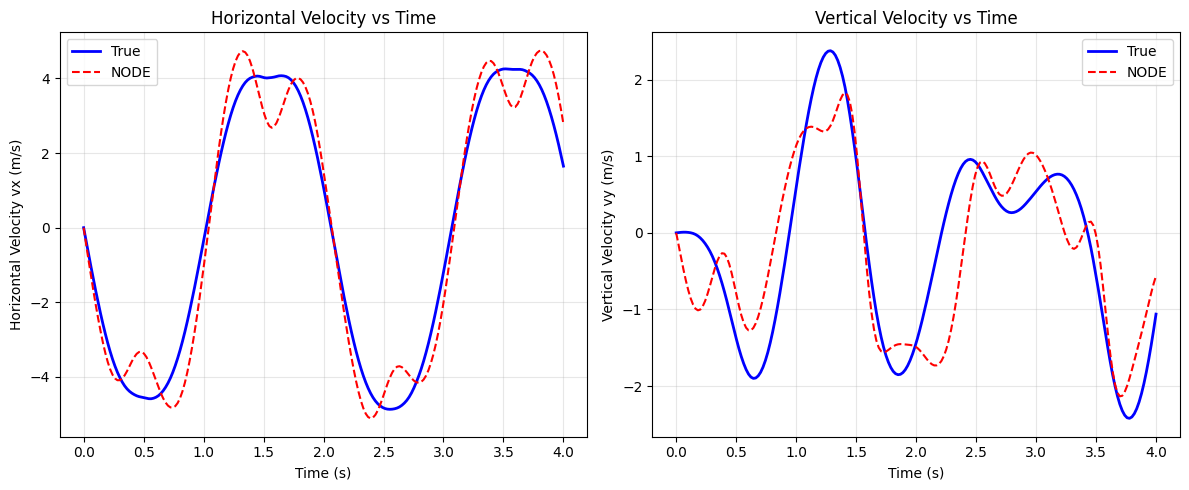

SUMMARY
     Spring Length r (m): RMSE = 0.040679, MAE = 0.032387
Radial Velocity r_dot (m/s): RMSE = 0.299838, MAE = 0.239270
             Angle θ (rad): RMSE = 0.072377, MAE = 0.057876
Angular Velocity θ_dot (rad/s): RMSE = 0.590799, MAE = 0.508554


In [ ]:
# ============================================================================
# COMPREHENSIVE VALIDATION PLOTS
# ============================================================================

# First, calculate energy properly
def calculate_energy(r, r_dot, theta, theta_dot, m=1.0, k=20.0, L0=1.0, g=9.81):
    """Calculate total energy of elastic pendulum"""
    # Kinetic energy
    v_squared = r_dot**2 + (r * theta_dot)**2
    KE = 0.5 * m * v_squared

    # Potential energy (spring + gravitational)
    spring_PE = 0.5 * k * (r - L0)**2
    gravitational_PE = m * g * r * (1 - np.cos(theta))

    return KE + spring_PE + gravitational_PE

# Calculate energy for true and predicted trajectories
energy_true = calculate_energy(state_true[0], state_true[1], state_true[2], state_true[3], m, k, L0, g)
energy_pred = calculate_energy(state_pred_np[:, 0], state_pred_np[:, 1],
                              state_pred_np[:, 2], state_pred_np[:, 3], m, k, L0, g)

# Calculate RMSE over time
rmse_over_time = np.sqrt(np.mean((state_true.T - state_pred_np) ** 2, axis=1))

# Calculate Cartesian velocities
def calculate_cartesian_velocities(r, r_dot, theta, theta_dot):
    """Convert polar velocities to Cartesian velocities"""
    vx = r_dot * np.sin(theta) + r * theta_dot * np.cos(theta)
    vy = -r_dot * np.cos(theta) + r * theta_dot * np.sin(theta)  # Corrected sign
    return vx, vy

# True Cartesian velocities
vx_true, vy_true = calculate_cartesian_velocities(state_true[0], state_true[1],
                                                 state_true[2], state_true[3])
# Predicted Cartesian velocities
vx_pred, vy_pred = calculate_cartesian_velocities(state_pred_np[:, 0], state_pred_np[:, 1],
                                                 state_pred_np[:, 2], state_pred_np[:, 3])

# ============================================================================
# PLOT 1: TIME SERIES COMPARISON (2x3 layout)
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: RMSE over time
axes[0, 0].plot(t_true, rmse_over_time, 'purple', linewidth=2)
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE vs Time')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(bottom=0)

# Plot 2: Spring length r(t)
axes[0, 1].plot(t_true, state_true[0], 'b-', linewidth=2, label='True')
axes[0, 1].plot(t_true, state_pred_np[:, 0], 'r--', linewidth=1.5, label='NODE')
axes[0, 1].axhline(y=L0, color='green', linestyle=':', alpha=0.7, label=f'Natural length ({L0}m)')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Spring Length r (m)')
axes[0, 1].set_title('Spring Length vs Time')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Radial velocity r_dot(t)
axes[0, 2].plot(t_true, state_true[1], 'b-', linewidth=2, label='True')
axes[0, 2].plot(t_true, state_pred_np[:, 1], 'r--', linewidth=1.5, label='NODE')
axes[0, 2].set_xlabel('Time (s)')
axes[0, 2].set_ylabel('Radial Velocity r_dot (m/s)')
axes[0, 2].set_title('Radial Velocity vs Time')
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Angle θ(t)
axes[1, 0].plot(t_true, np.degrees(state_true[2]), 'b-', linewidth=2, label='True')
axes[1, 0].plot(t_true, np.degrees(state_pred_np[:, 2]), 'r--', linewidth=1.5, label='NODE')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Angle θ (degrees)')
axes[1, 0].set_title('Pendulum Angle vs Time')
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Angular velocity θ_dot(t)
axes[1, 1].plot(t_true, state_true[3], 'b-', linewidth=2, label='True')
axes[1, 1].plot(t_true, state_pred_np[:, 3], 'r--', linewidth=1.5, label='NODE')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Angular Velocity θ_dot (rad/s)')
axes[1, 1].set_title('Angular Velocity vs Time')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Energy conservation
axes[1, 2].plot(t_true, energy_true, 'b-', linewidth=2, label='True')
axes[1, 2].plot(t_true, energy_pred, 'r--', linewidth=1.5, label='NODE')
axes[1, 2].set_xlabel('Time (s)')
axes[1, 2].set_ylabel('Total Energy (J)')
axes[1, 2].set_title('Energy Conservation')
axes[1, 2].legend(fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: CARTESIAN VELOCITIES (Separate plot)
# ============================================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_true, vx_true, 'b-', linewidth=2, label='True')
plt.plot(t_true, vx_pred, 'r--', linewidth=1.5, label='NODE')
plt.xlabel('Time (s)')
plt.ylabel('Horizontal Velocity vx (m/s)')
plt.title('Horizontal Velocity vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(t_true, vy_true, 'b-', linewidth=2, label='True')
plt.plot(t_true, vy_pred, 'r--', linewidth=1.5, label='NODE')
plt.xlabel('Time (s)')
plt.ylabel('Vertical Velocity vy (m/s)')
plt.title('Vertical Velocity vs Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# SUMMARY STATISTICS

print("SUMMARY")

for i, (var, unit) in enumerate(zip(variables, units)):
    mse_var = np.mean(errors[:, i]**2)
    rmse_var = np.sqrt(mse_var)
    mae_var = np.mean(errors[:, i])
    print(f"{var:>20} ({unit}): RMSE = {rmse_var:.6f}, MAE = {mae_var:.6f}")